In [1]:
# write out translations, along with a pickled numpy object which holds the glimpses
# for the n-best case, this object is (n_best, words, glimpses)

# truncate each suffix hyp in the n-best list according to some heuristic with the alignment model (i.e. a feature computed over the glimpses)
# evaluate performance as the heuristic changes



In [2]:
import codecs
import numpy

In [3]:
hyps_file='/media/1tb_drive/multilingual-multimodal/flickr30k/train/processed/test.imt_PROTO-DELETE-ME.hyps.out'
glimpse_file='/media/1tb_drive/multilingual-multimodal/flickr30k/train/processed/test.GLIMPSES_PROTO-DELETE-ME.npz'
source_file = '/media/1tb_drive/multilingual-multimodal/flickr30k/train/processed/test.GLIMPSES_PROTO-DELETE-ME.sources'
refs_file = '/media/1tb_drive/imt_models/suffix_scaled_cross_entropy_big_data_newstest2013_init-EN-DE_internal_data_dropout0.5_src_vocab80000_trg_vocab90000_emb300_rec1000_batch40/reference_suffixes.generated'

In [4]:
def get_lines(filename, lower=False, cutoff=None):
    with codecs.open(filename, encoding='utf8') as inp:
        lines = [l.split() for l in inp.read().strip().split('\n')][:cutoff]
        if lower:
            lines = [[w.lower() for w in l] for l in lines]
        return lines

In [5]:
hyp_lines = get_lines(hyps_file)
ref_lines = get_lines(refs_file)
source_lines = get_lines(source_file)
glimpses = numpy.load(glimpse_file)

In [6]:
len(glimpses[0][0][0])

11

In [7]:
# get the first-best glimpses from glimpses
glimpses = [g[0] for g in glimpses]

In [8]:
sum(glimpses[60][0])

0.9999999294814188

In [9]:
assert all(len(t) == len(g) for t,g in zip(hyp_lines, glimpses))
assert all(len(r) == len(glimpses[i][0]) for i,r in enumerate(source_lines))

In [10]:
# Now evaluate different pruning strategies
# BASELINE SCORES (NO TRUNCATION):INFO:__main__:IMT F1 SCORE: 0.244294277012, precision: 0.245880568086, recall: 0.244141178125

# TODO: cost is a better measure of risk?? -- what is the logic?

In [11]:
trans_tups = zip(source_lines, hyp_lines, ref_lines, glimpses)

In [12]:
len(trans_tups)

218

In [13]:
# minimum length of suffix is 1 (i.e. you have to predict something)
# best aligned word must be at least this much bigger than average 
# pruning_threshold = .8

In [14]:
glimpses[0][1]

array([  1.37069589e-02,   7.70028889e-01,   1.28089935e-01,
         4.45179828e-03,   2.42383890e-02,   1.96635779e-02,
         4.88192635e-03,   4.61603561e-03,   2.97636987e-04,
         2.41166465e-02,   5.90839889e-03], dtype=float32)

In [15]:
def prune_hyps_at_threshold(threshold, tups, cutoff=4, n=3):
    pruned_hyps = []
    for source, hyp, ref, glimpse in tups:
#         pruned_hyp = hyp[:cutoff]
        pruned_hyp = hyp[:1]

        for w, weights in zip(hyp[1:], glimpse[1:]):
            aligned_word = numpy.argmax(weights)
            sorted_weights = numpy.sort(weights)[::-1]
            best_weight = sorted_weights[0]
#             best_n_weights = sorted_weights[:n]

    #         print(best_weight)
    #         best_worst_ratio = sorted_weights[-1] / sorted_weights[0]
            if best_weight >= threshold:
                pruned_hyp.append(w)
#             if np.mean(best_n_weights) >= threshold:
#                 pruned_hyp.append(w)
            else:
                break
        pruned_hyps.append(pruned_hyp)
#         if len(pruned_hyp) < len(hyp):
#             print('original hyp: {}'.format(hyp))
#             print('pruned hyp: {}'.format(pruned_hyp))
    return pruned_hyps

In [16]:
def prune_hyps_at_cutoff(cutoff, tups, n=3):
    pruned_hyps = []
    for source, hyp, ref, glimpse in tups:
        pruned_hyp = hyp[:cutoff]
        pruned_hyps.append(pruned_hyp)
    return pruned_hyps

In [17]:
def max_achievable(hyps, refs):
    # cut hyps to the point where they only match the ref prefix
    matching_hyps = []
    for hyp,ref in zip(hyps, refs)[:100]:
        matching_hyp = []
        for i,hyp_w in enumerate(hyp):
            if i < len(ref) and ref[i] == hyp_w:
                matching_hyp.append(hyp_w)
            else:
                break
        matching_hyps.append(matching_hyp)
    return matching_hyps

In [18]:
# NOW compute IMT F1 for the pruned hyps, compare to IMT F1 for raw hyps
from nn_imt.evaluation import imt_f1
import numpy as np

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [19]:
def avg_imtF1(hyps, refs):
    f1s, ps, rs = tuple(np.mean(m) for m in zip(*[imt_f1(h,r) for h,r in zip(hyps,refs)]))
    return f1s, ps, rs

In [20]:
cutoffs = range(1,21)

In [21]:
cutoff_sets = [prune_hyps_at_cutoff(cutoff, trans_tups) for cutoff in cutoffs]
c_f1s, c_ps, c_rs = zip(*[avg_imtF1(cutoff_set, ref_lines) for cutoff_set in cutoff_sets])

In [22]:
thresholds = np.linspace(0.0, 1.0, num=50)

In [23]:
pruned_sets = [prune_hyps_at_threshold(thresh, trans_tups) for thresh in thresholds]
t_f1s, t_ps, t_rs = zip(*[avg_imtF1(pruned_set, ref_lines) for pruned_set in pruned_sets])

In [24]:
raw_f1s, raw_ps, raw_rs = avg_imtF1(hyp_lines, ref_lines)

In [25]:
2*((raw_ps*raw_rs) / (raw_ps+raw_rs))

0.24500778602056078

In [26]:
max_f1s, max_ps, max_rs = avg_imtF1(max_achievable(hyp_lines, ref_lines), ref_lines)

In [27]:
2*((max_ps*max_rs) / (max_ps+max_rs))

0.39919060127681627

In [28]:
max_ps

0.63

In [29]:
max_rs

0.29215535887203709

In [30]:
# now graph f1, precision, recall over threshold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pylab
pylab.rcParams['figure.figsize'] = (14.0, 12.0)
pylab.rcParams['axes.linewidth'] = 2. #set the value globally

In [31]:
avg_thresh_f1s = [2*((p*r) / (p+r)) for p,r in zip(t_ps, t_rs)]
avg_cutoff_f1s = [2*((p*r) / (p+r)) for p,r in zip(c_ps, c_rs)]

In [32]:
best_cutoff_idx = np.argmax(avg_cutoff_f1s)
# print(best_cutoff_idx)
print(avg_cutoff_f1s[best_cutoff_idx])
print(cutoffs[best_cutoff_idx])

0.282333664649
4


In [33]:
best_thresh_idx = np.argmax(avg_thresh_f1s)
print(best_thresh_idx)
print(avg_thresh_f1s[best_thresh_idx])
print(thresholds[best_thresh_idx])

21
0.274027254163
0.428571428571


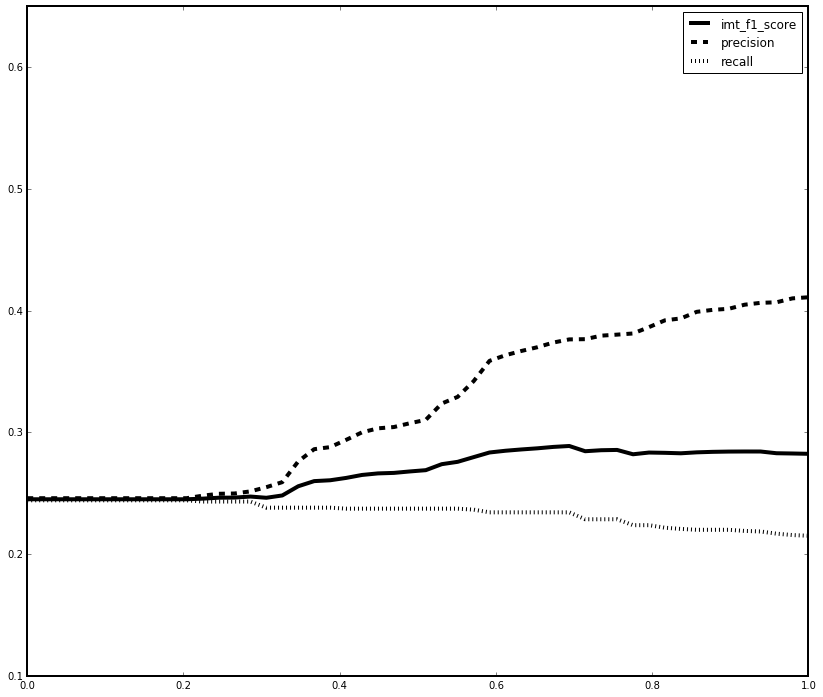

In [30]:
fig, ax = plt.subplots()

names = ['imt_f1_score', 'precision', 'recall']
metrics = [avg_thresh_f1s, t_ps, t_rs]
# styles = 	['solid' | 'dashed', 'dashdot', 'dotted' |
styles = ['solid', 'dashed', 'dotted']


# for i,key_points in enumerate(all_points):

for i in range(len(names)):
    name = names[i]
    x = thresholds
    y = metrics[i]
#     ax.scatter(x, y, s=70, c='red')
    plt.plot(x, y, 'k', label=name, linewidth=4.0, ls=styles[i])
    
    plt.ylim([0.1,0.65])
    

plt.legend()

In [20]:
thresholds

array([ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
        0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ])

In [ ]:
thresholds = np.linspace

In [17]:
# compare IMT F1 over matching hyps vs raw hyps
raw_f1s, raw_p, raw_r = tuple(np.mean(m) for m in zip(*[imt_f1(h,r) for h,r in zip(hyp_lines,ref_lines)]))
max_f1s, max_p, max_r = tuple(np.mean(m) for m in zip(*[imt_f1(h,r) for h,r in zip(pruned_hyps,ref_lines)]))

print('raw_f1s: {}, raw_p: {}, raw_r: {}'.format(raw_f1s, raw_p, raw_r))
print('max f1s: {}, max_p: {}, max_r: {}'.format(max_f1s, max_p, max_r))

raw_f1s: 0.244294277012, raw_p: 0.245880568086, raw_r: 0.244141178125
max f1s: 0.19325586391, max_p: 0.56001529052, max_r: 0.141309311685


In [ ]:
# now plot p, r, and f1 against alignment thresholds

In [16]:
len(pruned_hyps)

218

In [ ]:
# WORKING: for each target word, print the closest aligned source word
window_size = 1
top_n = 3
for i,t_seq in enumerate(trans):
    for j,w in enumerate(t_seq):
        weights_ij = glimpses[i][j]
        normed_weights = numpy.exp(weights_ij) / numpy.sum(numpy.exp(weights_ij))
        aligned_word = numpy.argmax(weights_ij)
        top_n_aligned_words = numpy.argsort(weights_ij)[::-1][:top_n]
        top_n_aligned_weights = weights_ij[top_n_aligned_words]
        percent_of_best = top_n_aligned_weights / top_n_aligned_weights[0]
        best_weight = top_n_aligned_weights[0]
        avg_weight = numpy.mean(weights_ij)
        best_avg_percent = avg_weight / best_weight
        top_n_src_idxs = [seq[s] for s in top_n_aligned_words]
        src_aligned_idx_window = seq[aligned_word-window_size:aligned_word+window_size+1]
        print('aligned window: {}'.format((self.trg_ivocab[w], [self.src_ivocab[sw] for sw in src_aligned_idx_window])))
        print('top n aligned: {}'.format((self.trg_ivocab[w], [self.src_ivocab[sw] for sw in top_n_src_idxs])))
        print('percent from best: {}'.format(percent_of_best))
        # print('normed weights: {}'.format(weights_ij / numpy.sum(weights_ij)))
        # print('weight distribution: {}'.format(normed_weights))
import ipdb;ipdb.set_trace()

In [16]:
len(glimpses[20])

16

In [10]:
assert len(hyp_lines) == len(ref_lines) == len(glimpses)

TypeError: len() of unsized object